# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.776455,True,7.127610
1,-2.683864,False,-5.707601
2,-0.448552,False,-2.483746
3,-0.385375,False,-0.744725
4,0.227717,False,0.407495
...,...,...,...
995,-1.143809,False,-2.950720
996,-1.567100,False,-5.356781
997,-1.792233,False,-5.852981
998,-0.840831,False,-0.623573


<AxesSubplot:xlabel='v0'>

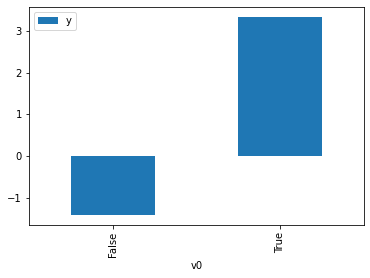

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

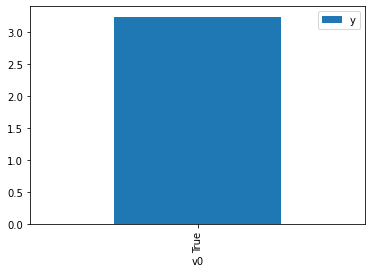

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.984048,False,-3.411204,0.976979,1.023563
1,-1.640299,False,-3.902026,0.957105,1.044817
2,1.138230,False,3.054754,0.109922,9.097324
3,-0.015472,False,-1.196752,0.516554,1.935907
4,-0.604633,False,-2.349184,0.762810,1.310942
...,...,...,...,...,...
995,1.507008,False,4.318191,0.058345,17.139348
996,-1.014575,False,-4.555769,0.873787,1.144444
997,-2.717871,False,-6.040382,0.994063,1.005973
998,-0.126003,False,-1.807830,0.567821,1.761119


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.742938,True,6.986853,0.794492,1.258666
1,0.218969,True,4.575540,0.591999,1.689192
2,-1.211671,True,2.157353,0.090834,11.009099
3,-1.159913,True,2.450365,0.099151,10.085601
4,-1.333682,True,2.091381,0.073666,13.574767
...,...,...,...,...,...
995,-0.080130,True,2.336063,0.453344,2.205833
996,-0.169521,True,4.376790,0.412326,2.425266
997,-0.855582,True,2.631998,0.162806,6.142297
998,-0.567670,True,3.512827,0.249924,4.001219


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.940
Model:                            OLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                              7870.
Date:                Sat, 13 Aug 2022   Prob (F-statistic):                        0.00
Time:                        01:36:55   Log-Likelihood:                         -1410.7
No. Observations:                1000   AIC:                                      2825.
Df Residuals:                     998   BIC:                                      2835.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1694      0.027     81.651      0.000       2.117       2.222
x2             5.0127      0.056     88.788      0.000       4.902       5.124
==============================================================================
Omnibus:                        4.294   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.117   Jarque-Bera (JB):                4.290
Skew:                           0.137   Prob(JB):                        0.117
Kurtosis:                       2.834   Cond. No.                         2.13
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""